### This file will do data analysis and filter the relevant movie id for the next process

### Setting Up

In [20]:
from pyspark import SparkConf, SparkContext
import pandas as pd
import numpy as np
from math import sqrt
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
conf = SparkConf().setMaster("local[*]")
sc = SparkContext(conf=conf)
rating_data = sc.textFile("full_data/ratings.dat")

In [3]:
def _extract_user_rating(line):
    data = line.split('::')
    return (int(data[1]), float(data[2]))

In [4]:
movie_list = rating_data.map(_extract_user_rating) \
        .aggregateByKey((0, 0), lambda g1,v2: (g1[0]+v2, g1[1]+1), 
                    lambda g1,g2: (g1[0]+g2[0], g1[1]+g2[1])) \
        .map(lambda line: (line[0], line[1][0], line[1][1])).persist()

In [60]:
movies = movie_list.collect()

In [62]:
movies_pd = pd.DataFrame(movies)
movies_pd[3] = movies_pd[1]/movies_pd[2]
movies_pd.columns = ['movie_id', 'sum_rating', 'count', 'avg_rating']
movies_pd = movies_pd[['movie_id', 'count', 'avg_rating']]

### Data Analysis

In [48]:
rating_data.top(5)

['9::920::2.5::1162141425',
 '9::7361::5::1162141558',
 '9::50::5::1162141584',
 '9::44761::5::1162141616',
 '9::4226::5::1162141582']

In [47]:
print("Number of ratings: ", rating_data.count())

Number of ratings:  10000054


In [50]:
movies_pd.head()

,movie_id,sum_rating,count,avg_rating
0,480,119480.5,32631,3.661564
1,520,24291.5,8062,3.013086
2,616,13779.5,4074,3.382302
3,376,22592.0,6892,3.278003
4,648,71409.5,21085,3.386744


In [51]:
print("Number of movies:", movies_pd.count()[0])

Number of movies: 10677


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d5c140518>]], dtype=object)

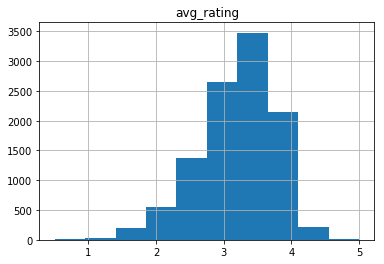

In [45]:
movies_pd.hist('avg_rating')

In [31]:
(movies_pd['avg_rating'] < 2.5).sum()

1268

How many ratings for each movie


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d5c104048>]], dtype=object)

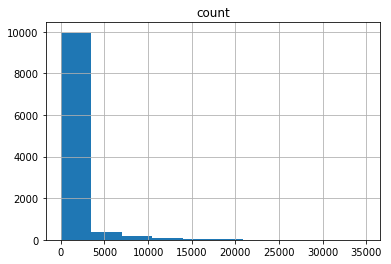

In [52]:
print('How many ratings for each movie')
movies_pd.hist('count')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d5c3d0b00>]], dtype=object)

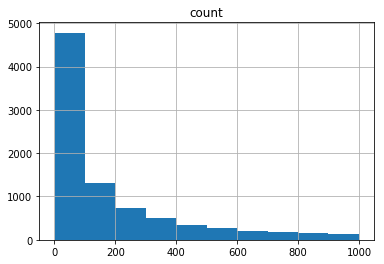

In [35]:
movies_pd[movies_pd['count']<1000].hist('count')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d5c2f6c18>]], dtype=object)

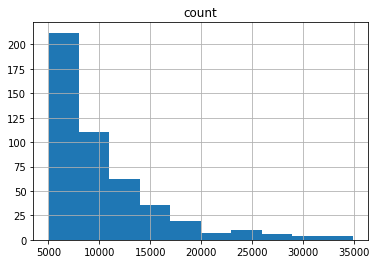

In [38]:
movies_pd[movies_pd['count']>5000].hist('count')

In [39]:
movies_pd[movies_pd['count']<10].count()

movie_id      969
sum_rating    969
count         969
avg_rating    969
dtype: int64

In [63]:
movies_pd.describe()

,movie_id,count,avg_rating
count,10677.000000,10677.000000,10677.000000
mean,13105.383160,936.597733,3.191955
std,17792.295767,2487.328304,0.566975
min,1.000000,1.000000,0.500000
25%,2754.000000,34.000000,2.847826
50%,5434.000000,135.000000,3.265351
75%,8710.000000,626.000000,3.608696
max,65133.000000,34864.000000,5.000000


In [56]:
movies_pd.quantile(.1)

movie_id      1089.600000
sum_rating      30.800000
count           11.000000
avg_rating       2.409814
Name: 0.1, dtype: float64

## Filtering movies

### Keep only the movies rated more than 100 and average rating more than 4

In [41]:
filtered_movies = movies_pd[((movies_pd['count']>100) & (movies_pd['avg_rating'] > 4))]
filtered_movies.count()

movie_id      364
sum_rating    364
count         364
avg_rating    364
dtype: int64

In [43]:
filtered_movies['movie_id'].to_csv('input/movie_list.txt',index=False)